<a href="https://colab.research.google.com/github/5-VED/Assignment/blob/master/Pneumonia_Prediction_using_Transfer_Learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing required libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf
from tensorflow import keras 

from keras.layers import Flatten,Lambda,Dense,Input
from keras.models import Model
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg19 import VGG19

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from glob import glob

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vedparmar","key":"fd7413fe236c9872d846fc86f43165da"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Downloading Datasets from kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:31<00:00, 24.2MB/s]
100% 2.29G/2.29G [00:31<00:00, 78.5MB/s]


In [ ]:
#Extracting the zip file
from zipfile import ZipFile
file_name='chest-xray-pneumonia.zip'

with ZipFile(file_name,'r') as zip:
    zip.extractall()
    print('Done')

Done


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices() 

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2119918013167374440, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 129109766703790933
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10530295108027672490
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14640891840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3779519564212129702
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
#Resizing all the images to 224 pixels
IMAGE_SIZE = [224,224]

train_data = '/content/chest_xray/train'
test_data = '/content/chest_xray/test'

In [ ]:
#Importing the vgg16 and dropping the first and last layer 
#Setting the weights of imagenet

vgg=VGG16(input_shape=IMAGE_SIZE+[3],weights='imagenet',include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
#Don't retrain the weights
for layer in vgg.layers:
    layer.trainable=False

In [ ]:
#Useful for getting number of output classes
folders=glob('/content/chest_xray/train/*')

In [ ]:
#Printing the length of folders
print(len(folders))

2


In [ ]:
#Flattening the layer
x=Flatten()(vgg.output)

In [ ]:
prediction=Dense(len(folders),activation='softmax')(x)

#Create a Model obj
model=Model(inputs=vgg.input,outputs=prediction)

#View the structure of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
#Compiling the Model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
#Using image Data Generator to import image from the dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#Make sure that we give the same size for training as initialized
training_set=train_datagen.flow_from_directory('/content/chest_xray/train',
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical'
)

Found 5216 images belonging to 2 classes.


In [ ]:
test_set=train_datagen.flow_from_directory('/content/chest_xray/test',
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical')

Found 624 images belonging to 2 classes.


In [ ]:
#Fit the model and train it 

r=model.fit_generator(
    training_set,
    validation_data=test_set,
    epochs=5,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

Epoch 1/5
163/163 [==============================] - 119s 731ms/step - loss: 0.2003 - accuracy: 0.9222 - val_loss: 0.5912 - val_accuracy: 0.7933
Epoch 2/5
163/163 [==============================] - 117s 718ms/step - loss: 0.1155 - accuracy: 0.9544 - val_loss: 0.5649 - val_accuracy: 0.8205
Epoch 3/5
163/163 [==============================] - 117s 717ms/step - loss: 0.0951 - accuracy: 0.9640 - val_loss: 0.4342 - val_accuracy: 0.8782
Epoch 4/5
163/163 [==============================] - 116s 710ms/step - loss: 0.0845 - accuracy: 0.9680 - val_loss: 0.4143 - val_accuracy: 0.8606
Epoch 5/5
163/163 [==============================] - 120s 734ms/step - loss: 0.0926 - accuracy: 0.9649 - val_loss: 0.5719 - val_accuracy: 0.8349


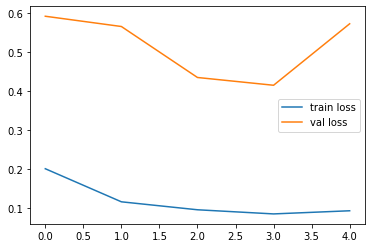

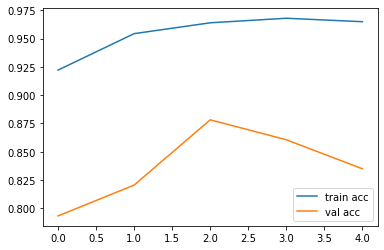

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# save it as a h5 file
model.save('model_vgg16.h5')